# Loading model

In [1]:
import torch
from qwerty_qwen2_update import QwertyQwen2ForCausalLM
from transformers import Qwen2ForCausalLM, Qwen2Tokenizer, CLIPImageProcessor, Trainer
from typing import Dict, Sequence
import os
import conversation 
from PIL import Image

device = 'cuda:1'
model_name_or_path: str = "/data/uchiha_ssd2/fengqi/241121_qwerty/251124_230127/"
vision_tower_name_or_path: str = "openai/clip-vit-large-patch14-336"

model = QwertyQwen2ForCausalLM.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.bfloat16,
    )
model.to(device)
model.config.use_cache = True
tokenizer = Qwen2Tokenizer.from_pretrained(model_name_or_path)
image_processor = CLIPImageProcessor.from_pretrained(vision_tower_name_or_path)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

# Loading weights

In [2]:
from safetensors import safe_open
folder_path = model_name_or_path
merged_weights: Dict[str, torch.Tensor] = {}
safetensors_files = [
    f for f in os.listdir(folder_path) 
    if f.endswith('.safetensors')
]

for file_name in safetensors_files:
    file_path = os.path.join(folder_path, file_name)
    with safe_open(file_path, framework="pt", device="cpu") as f:
        keys = f.keys()
        
        for key in keys:
            if key in merged_weights:
                print(f"警告: 键 {key} 在多个文件中出现,将使用文件 {file_name} 中的值")
            tensor = f.get_tensor(key)
            merged_weights[key] = tensor

for key in model.state_dict().keys():
    if key.startswith('vision_model'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        #model.state_dict()[key] = merged_weights['model.' + key] 据说，直接修改 state_dict() 中的值通常是不被推荐的操作，因为 state_dict() 是一个浅拷贝，而不是模型参数的直接映射。这种操作可能会导致模型参数与优化器不匹配。
    if key.startswith('mm_projector'):
        print(key)
        assert model.state_dict()[key].shape == merged_weights['model.' + key].shape, "未能正确加载模型参数"
        model.load_state_dict({
            **model.state_dict(),
            **{key: merged_weights['model.' + key] for key in merged_weights}
        }, strict=False)
        
missing_keys, unexpected_keys = model.load_state_dict({
    **model.state_dict(),
    **{key: merged_weights[key] for key in merged_weights}
}, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

Missing keys: []
Unexpected keys: []


In [3]:
def response(image_path:str,prompt :str) -> None:
    cur_conv = conversation.conv_qwen2_5.copy()
    cur_image = Image.open(image_path)
    image = image_processor(cur_image, return_tensors='pt')['pixel_values']
    cur_conv.append_message(['USER',(prompt,cur_image)])
    text = cur_conv.get_prompt()
    text += "\n<|im_start|>assistant\n"
    input_ids = tokenizer(text,return_tensors="pt",add_special_tokens=False)['input_ids'][0]
    input_ids = input_ids.unsqueeze(0)
    attention_mask = torch.ones_like(input_ids)
    labels = torch.arange(input_ids.shape[-1]).unsqueeze(0)

    image = image.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    output_ids = model.generate(
        inputs=input_ids,                  # 输入 tokens
        max_length=1024,                      
        num_return_sequences=1,             # 返回生成的序列数
        temperature=0.7,                    # 控制生成的多样性
        top_k=50,                           # 限制最高概率的 K 个标记
        top_p=0.95,                         # 过滤累积概率小于 P 的标记
        do_sample=True,                     # 使用采样生成（而非贪心算法）
        images=image,
        attention_mask=attention_mask,
        labels=labels,
        use_cache=True,
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Generated text:\n\n{generated_text}")

# Image 6

In [4]:
image_path:str = "test_images/6.U.jpg"

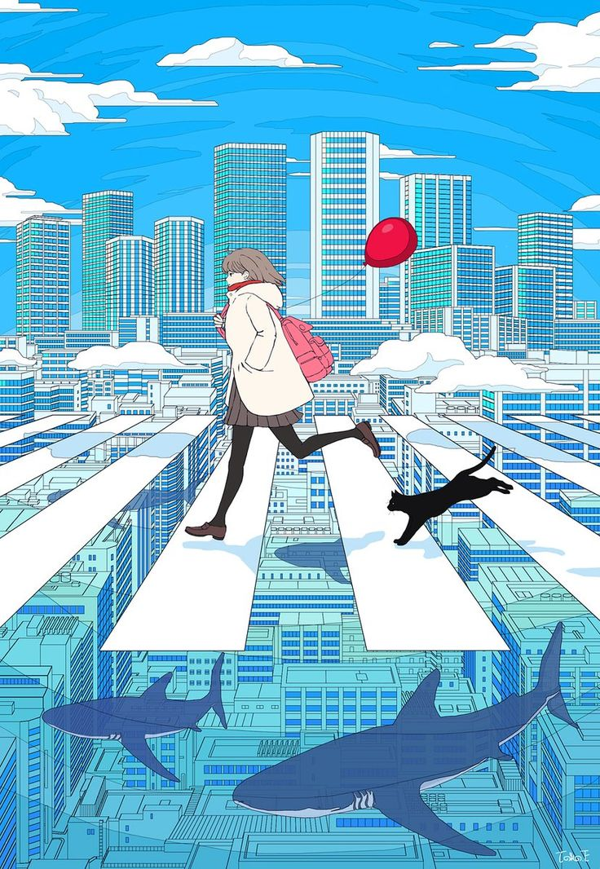

In [5]:
image = Image.open(image_path)
image2 = image.resize((600,int(600*image.height/image.width)))
image2

In [6]:
prompt :str = "<image>\nDescribe this picture concisely."

In [7]:
response(image_path,prompt)

Generated text:

The image depicts a woman walking across the street in an artist's title: picture, " image is a surreal urban user's scene shows a colorful and imaginative depiction of a surreal urban anime, hand city urban anime, cartoon, fantast city and dreamuser scene features a young art, fantasy the city, fantastical artwork scene presents story by hand by hand, surreal city, surreal scene portrays scene featuring narrative scene showcases urban version animation artist tells woman portrays urban illustration narrative featuring, featuring of a young artist featuring city animation illustrates of a young scene showcases a woman or comic fantasy setting combining, combining urban story artist with elements artist that combines a young, featuring an imaginative urban depiction featuring a woman city featuring a woman, surreal urban setting combining combining, surreal urban city featuring a woman featuring a woman, depicting story featuring a woman featuring a woman, the urban sto

In [8]:
prompt :str = "<image>\nIs there anything unusual in this picture?"

In [9]:
response(image_path,prompt)

Generated text:

Yes, the unusual elements in this picture of the presence of the image of the image, there is the picture, there is the image features the picture image features a cartoon cartoon, there are the picture, the image is that picture, there are the scene of the image is a drawing the unusual cartoon is a cartoon is an unusual cartoon that the unusual, there is that a surrealism is a surrealism is a surreal and surrealism surreal nature, fantast and the woman surreal and the depicted surreal and dream surreal and dream animation, depicting, depicting, a dream, depicting, a key, depicting composition, depicting a depiction, fantastistic artwork, dream, the picture, depicting a young, a young, a depiction, dream, the image depicts, city, a woman, dreamlike a depiction a woman, dream-like, dreamlike, fantasy, dreamlike, urban, dreamlike, dreamlike, dreamlike, dream-like, dreamlike, urban, dream-like, dreamlike, urban, dreamlike, city, dreamlike, dreamlike, city, dreamlike, urb